In [2]:
import pathlib as pl
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sympy as sp
import mahotas
%matplotlib inline
sp.init_printing()

## Basic Processing Analysis

For the first step of the Build phase, I will examine the photos for quality and consistency to ensure I can perform all image processing required for computer vision and photogrammetry operations. This includes:
* Examining image matrix operations
* Setting up a calibration collection

In [18]:
original_poles = [str(photo) for photo in sorted(pl.Path('../data/original_poles').glob('*.jpg'))]
original_midspans = [str(photo) for photo in sorted(pl.Path('../data/original_midspans').glob('*.jpg'))]
annotated_poles = [str(photo) for photo in sorted(pl.Path('../data/annotated_poles').glob('*.jpg'))]
annotated_midspans = [str(photo) for photo in sorted(pl.Path('../data/annotated_midspans').glob('*.jpg'))]

We'll start off with some basic imaging processing to find some workable configurations for the actual detection work. To do this, we load the first file in the original_main collection and examine its contents:

In [6]:
main_image_path = original_poles[0]
main_image_path

'../data/original_poles/original_000_1_main.jpg'

Images are loaded using OpenCV's imread function, which reads the photo's file and returns an image object ready for further processing:

In [7]:
sample_main = cv2.imread(main_image_path)

Recalling our EDA work, the photo should have a resolution of 3840x2560. We can verify this using the shape() function:

In [8]:
sample_main.shape

In [9]:
sample_main.size

This call also returns the number of channels in the image, which total three. The channels represent the different layers of the image's color space, such as RGB (for red, green, and blue), the color space of most modern digital images.

Next let's view the image to see what we're working with, using Matplotlib, a popular Python visualization library. For this, we'll need to pay attention to an important detail: OpenCV's built-in color space is BGR (blue, green, red), while Matplotlib defaults to RGB, so swapping color spaces is necessary to correctly colorize each pixel.

This can be done with the cvtColor() function in cv2:

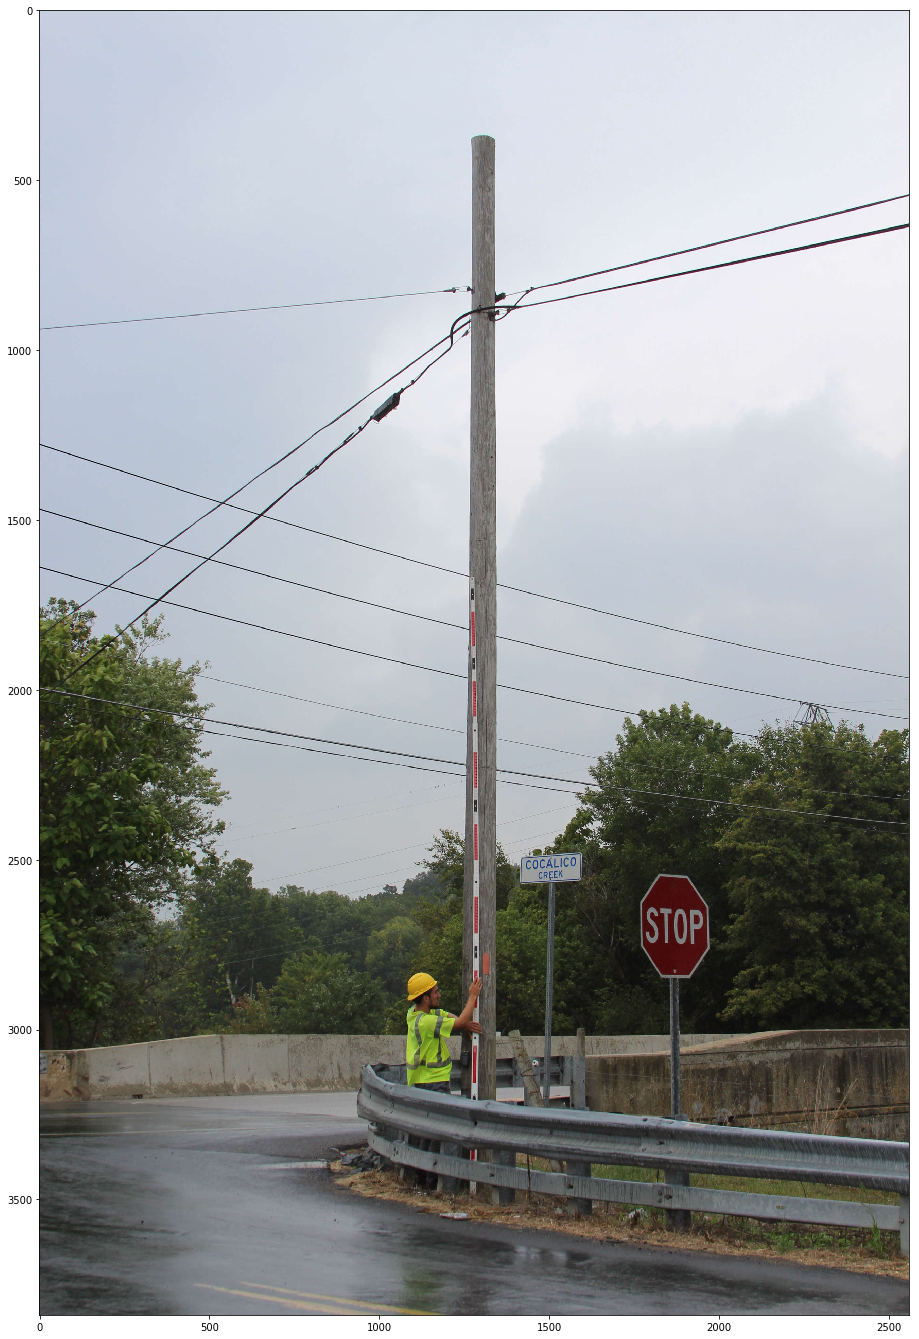

In [11]:
fig = plt.figure(figsize = (40, 24))
plt.imshow(cv2.cvtColor(sample_main, cv2.COLOR_BGR2RGB), aspect='equal')
plt.show()

There are a few important aspects of the image that are essential to our work here:
* The axis marks the pixel dimensions, so this can help with identifying and validating heights (more on this later)
* The points of interest for us are the field surveyor, the measuring stick he's hold, the pole, and everything on the pole

We'll focus on each of these as we work through the processing activities below. But before we move on, you might be wondering at this point where data science plays a role in all this? Let's have a look at how the above image is actually stored as a data structure in memory to provide some context, using a 5x5 slice of pixels representing a small corner of the image:

In [12]:
sp.Array(sample_main[0:5, 0:5])

⎡⎡137  121  114⎤  ⎡212  196  189⎤  ⎡244  228  221⎤  ⎡234  218  211⎤  ⎡240  224
⎢⎢             ⎥  ⎢             ⎥  ⎢             ⎥  ⎢             ⎥  ⎢        
⎢⎢188  172  165⎥  ⎢231  215  208⎥  ⎢235  219  212⎥  ⎢218  202  195⎥  ⎢225  209
⎢⎢             ⎥  ⎢             ⎥  ⎢             ⎥  ⎢             ⎥  ⎢        
⎢⎢227  211  204⎥  ⎢238  222  215⎥  ⎢224  208  201⎥  ⎢212  196  189⎥  ⎢221  205
⎢⎢             ⎥  ⎢             ⎥  ⎢             ⎥  ⎢             ⎥  ⎢        
⎢⎢224  208  201⎥  ⎢225  209  202⎥  ⎢219  203  196⎥  ⎢222  206  199⎥  ⎢232  216
⎢⎢             ⎥  ⎢             ⎥  ⎢             ⎥  ⎢             ⎥  ⎢        
⎣⎣217  201  194⎦  ⎣216  200  193⎦  ⎣220  204  197⎦  ⎣229  213  206⎦  ⎣232  216

  217⎤⎤
     ⎥⎥
  202⎥⎥
     ⎥⎥
  198⎥⎥
     ⎥⎥
  209⎥⎥
     ⎥⎥
  209⎦⎦

Under the hood, images are simply matrices (or multidimentional arrays, in Python)! Each pixel is represented by a triple of values from 0 to 255, each representing (in the order of OpenCV) the intensities of blue, green, and red channels that together make up what we see on the screen. A single pixel can be accessed with common array indexing, like this:

In [13]:
sample_main[0, 0]

array([137, 121, 114], dtype=uint8)

Beyond this basic representation, however, is any number of layers of visual information that are the building blocks for what we see. Using CV, we're able to break images down into their component parts and access and analyze features in ways not unlike a traditional dataset with rows and columns.

One of the first ways an image is broken down for analysis is to convert it from color to grayscale, which simplifies the matrix from a three dimensional space to a one dimensional space that still contains nearly all the necessary visual data for our analysis needs. Let's convert our sample image to demonstrate:

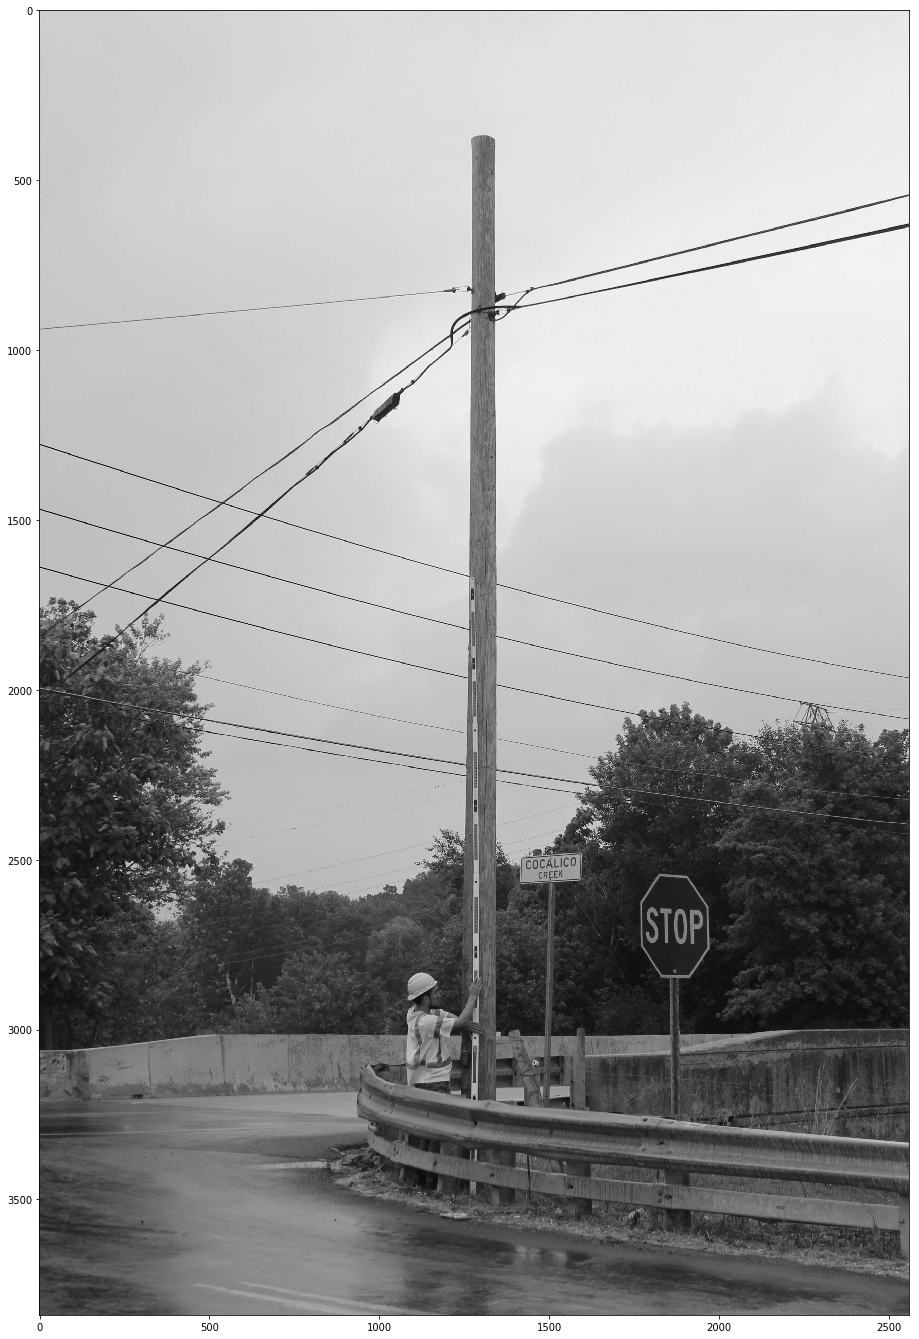

In [15]:
plt.figure(figsize = (40, 24))
sample_main_gray = cv2.cvtColor(sample_main, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(sample_main_gray, cv2.COLOR_GRAY2RGB))
plt.show()

As you can see, by converting the image to grayscale, we haven't reduced the overall resolution of the image. This is confirmed by checking the "shape" or dimensions of the image:

In [16]:
sample_main_gray.shape

What has changed, however, is that instead of three channels for BGR values, we now only need one channel for the spectrum from black (0) to white (255). Accessing a single pixel, then, returns a single value:

In [17]:
sample_main_gray[0, 0]

121

So while the number of pixels hasn't changed, the amount of data needed to represent them has been reduced to one third the size, and thus results in a more simplified maxtrix to do calculations against. We illustrate this in several ways below:

In [14]:
print("The grayscale version is {0}x{1}, for a total size of {2} pixel values".format(
    sample_main_gray.shape[0], sample_main_gray.shape[1], sample_main_gray.size))

The grayscale version is 3840x2560, for a total size of 9830400 pixel values


In [38]:
print("The color version is {0}x{1}x{2}, for a total size of {3} pixel values".format(
    sample_main.shape[0], sample_main.shape[1], sample_main.shape[2], sample_main.size))

The color version is 3840x2560x3, for a total size of 29491200 pixel values


Here is the same 5x5 pixel slice, converted to grayscale, which illustrates how much more simple the image representation is:

In [39]:
sp.Array(sample_main_gray[0:5, 0:5])

⎡121  172  211  208  201⎤
⎢                       ⎥
⎢196  215  222  209  200⎥
⎢                       ⎥
⎢228  219  208  203  204⎥
⎢                       ⎥
⎢218  202  196  206  213⎥
⎢                       ⎥
⎣224  209  205  216  216⎦